# Mutual Funds & ETFs Performance Prediction
## ML ZoomCamp 2025 - Midterm Project

### Project Overview
This notebook implements machine learning solutions for **four distinct investment analysis problems**:

1. **Regression**: Predict 1-year fund returns
2. **Binary Classification**: Classify funds as good/poor investments
3. **Multi-class Classification**: Predict risk ratings
4. **Recommendation System**: Find similar funds

### Table of Contents
1. Data Loading & Initial Exploration
2. Data Cleaning & Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Problem 1: Regression (1-Year Return Prediction)
6. Problem 2: Binary Classification (Investment Quality)
7. Problem 3: Multi-class Classification (Risk Rating)
8. Feature Importance Analysis
9. Model Comparison & Selection
10. Final Model Evaluation
11. Conclusions & Next Steps

## 1. Data Loading & Initial Exploration

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Models
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

# Utilities
import pickle
import os

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the mutual funds data
df_mutual = pd.read_csv('MutualFunds.csv')
df_etf = pd.read_csv('ETFs.csv')

print(f"Mutual Funds shape: {df_mutual.shape}")
print(f"ETFs shape: {df_etf.shape}")
print(f"\nTotal funds: {len(df_mutual) + len(df_etf):,}")

Mutual Funds shape: (23783, 298)
ETFs shape: (2310, 142)

Total funds: 26,093


In [3]:
# Combine datasets
df = pd.concat([df_mutual, df_etf], axis=0, ignore_index=True)
print(f"Combined dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")

Combined dataset shape: (26093, 300)
Number of features: 300


In [4]:
# Display first few rows
df.head()

,fund_symbol,quote_type,region,fund_short_name,fund_long_name,currency,initial_investment,subsequent_investment,fund_category,fund_family,exchange_code,exchange_name,exchange_timezone,management_name,management_bio,management_start_date,total_net_assets,year_to_date_return,day50_moving_average,day200_moving_average,week52_high_low_change,week52_high_low_change_perc,week52_high,week52_high_change,week52_high_change_perc,...,load_adj_return_3years,load_adj_return_5years,load_adj_return_10years,sustainability_score,sustainability_rank,esg_peer_group,esg_peer_count,esg_score,peer_esg_min,peer_esg_avg,peer_esg_max,environment_score,peer_environment_min,peer_environment_avg,peer_environment_max,social_score,peer_social_min,peer_social_avg,peer_social_max,governance_score,peer_governance_min,peer_governance_avg,peer_governance_max,avg_vol_3month,avg_vol_10day
0,AAAAX,MutualFund,US,DWS RREEF Real Assets Fund - Cl,DWS RREEF Real Assets Fund - Class A,USD,1000.0,50.0,World Allocation,DWS,NAS,Nasdaq,America/New_York,John Vojticek,Co-Head of Liquid Real Assets / Chief Investme...,2015-01-15,2.979347e+09,0.21026,12.788,12.369,2.44,0.18683,13.06,-0.51,-0.03905,...,0.0835,0.0707,0.0409,22.46,31.0,US Fund World Allocation,377.0,22.46,19.55,23.59,28.93,8.42,1.93,5.05,10.58,7.43,5.98,9.07,11.30,5.43,4.26,7.14,8.11,NaN,NaN
1,AAAEX,MutualFund,US,AllianzGI Health Sciences Fund,Virtus AllianzGI Health Sciences Fund Class P,USD,1000000.0,NaN,Health,Virtus,NAS,Nasdaq,America/New_York,Christopher Chin,NaN,2020-08-27,1.953489e+08,0.19077,40.513,38.650,8.53,0.20256,42.11,-2.77,-0.06578,...,0.1795,0.1448,0.1401,27.05,51.0,US Fund Health,168.0,27.05,21.07,27.98,36.79,1.42,0.34,1.43,3.27,12.96,9.52,12.87,15.08,8.40,4.96,7.68,10.30,NaN,NaN
2,AAAFX,MutualFund,US,NaN,American Century One Choice Blend+ 2015 Portfo...,USD,2500.0,50.0,Target-Date 2015,American Century Investments,NAS,Nasdaq,America/New_York,Scott A. Wilson,"Mr. Wilson, Vice President and Portfolio Manag...",2021-03-10,2.594600e+04,NaN,10.544,10.392,0.76,0.07096,10.71,-0.29,-0.02708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAGX,MutualFund,US,Thrivent Large Cap Growth Fund,Thrivent Large Cap Growth Fund Class A,USD,2000.0,50.0,Large Growth,Thrivent Funds,NAS,Nasdaq,America/New_York,Lauri Brunner,Ms. Brunner has been with Thrivent Financial s...,2018-09-30,2.078607e+09,0.24559,18.485,17.294,4.64,0.23955,19.37,-1.34,-0.06918,...,0.2287,0.2269,0.1624,20.55,26.0,US Fund Large Growth,1333.0,20.55,17.95,21.44,31.11,2.04,1.15,2.70,5.81,10.13,7.25,10.14,11.97,8.03,5.30,7.54,8.90,NaN,NaN
4,AAAHX,MutualFund,US,NaN,American Century One Choice Blend+ 2015 Portfo...,USD,5000000.0,NaN,Target-Date 2015,American Century Investments,NAS,Nasdaq,America/New_York,Scott A. Wilson,"Mr. Wilson, Vice President and Portfolio Manag...",2021-03-10,2.594600e+04,NaN,10.552,10.398,0.77,0.07183,10.72,-0.29,-0.02705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Column information
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26093 entries, 0 to 26092
Columns: 300 entries, fund_symbol to avg_vol_10day
dtypes: float64(279), object(21)
memory usage: 59.7+ MB


In [6]:
# Basic statistics
df.describe()

,initial_investment,subsequent_investment,total_net_assets,year_to_date_return,day50_moving_average,day200_moving_average,week52_high_low_change,week52_high_low_change_perc,week52_high,week52_high_change,week52_high_change_perc,week52_low,week52_low_change,week52_low_change_perc,fund_yield,morningstar_overall_rating,morningstar_risk_rating,last_dividend,last_cap_gain,annual_holdings_turnover,fund_annual_report_net_expense_ratio,category_annual_report_net_expense_ratio,fund_prospectus_net_expense_ratio,fund_prospectus_gross_expense_ratio,fund_max_12b1_fee,...,load_adj_return_1year,load_adj_return_3years,load_adj_return_5years,load_adj_return_10years,sustainability_score,sustainability_rank,esg_peer_count,esg_score,peer_esg_min,peer_esg_avg,peer_esg_max,environment_score,peer_environment_min,peer_environment_avg,peer_environment_max,social_score,peer_social_min,peer_social_avg,peer_social_max,governance_score,peer_governance_min,peer_governance_avg,peer_governance_max,avg_vol_3month,avg_vol_10day
count,1.648500e+04,8943.000000,2.602900e+04,23382.000000,26091.000000,26091.000000,25805.000000,25805.000000,25805.000000,25728.000000,25728.000000,25805.000000,24642.000000,24642.000000,20281.000000,21976.000000,21976.000000,17282.000000,7.000000,23335.000000,25868.000000,24573.000000,23567.000000,23705.000000,10892.000000,...,23225.000000,22092.000000,20893.000000,16711.000000,15407.000000,15407.000000,15407.000000,15407.000000,15407.000000,15407.000000,15407.000000,15388.000000,14839.000000,14839.000000,14839.000000,15388.000000,14839.000000,14839.000000,14839.000000,15388.000000,14839.000000,14839.000000,14839.000000,2.310000e+03,2.295000e+03
mean,5.179181e+06,1015.925752,4.710074e+09,0.093485,25.851330,25.262516,5.373606,0.152315,27.552388,-2.330901,-0.067472,22.178781,3.193877,0.015936,0.017654,3.103340,3.069121,0.119261,3.428571,0.958489,0.010036,0.008884,0.010473,0.019451,0.004995,...,0.276768,0.101745,0.099824,0.078628,23.767634,51.141884,621.724216,23.767634,19.656378,23.796062,29.598614,3.633445,2.375074,4.357856,7.675547,8.043626,6.906983,9.346850,11.308239,6.210819,5.387539,7.219275,8.917380,5.100906e+05,6.800002e+05
std,9.253584e+07,11023.969484,2.123636e+10,0.082276,35.222923,33.513440,10.979405,0.100896,37.743311,5.362767,0.070567,28.162159,7.750413,15.927431,0.024296,1.082413,1.106317,0.420173,4.755949,5.512020,0.005854,0.002907,0.005793,0.155496,0.003224,...,0.205244,0.071565,0.071661,0.053196,2.996519,26.982829,450.141216,2.996519,2.380491,2.595710,3.886517,2.226826,1.208774,1.498273,2.838513,3.674170,1.167251,1.204409,1.732701,2.800713,0.748176,0.820705,1.364138,3.114726e+06,4.289224e+06
min,1.000000e+01,1.000000,1.000000e+01,-0.522800,1.279000,1.325000,0.000000,0.000000,1.700000,-150.640000,-0.941720,-0.040000,-3.150000,-2500.000000,0.000100,1.000000,1.000000,0.000000,1.000000,0.004200,0.000100,0.001100,0.000100,0.000100,0.000100,...,-0.717100,-0.510400,-0.475700,-0.407100,8.250000,0.000000,1.000000,8.250000,8.240000,16.200000,18.890000,0.000000,0.310000,0.750000,0.830000,0.000000,2.300000,4.410000,5.860000,0.000000,2.610000,3.040000,3.310000,1.900000e+01,1.000000e+01
25%,1.000000e+03,50.000000,1.207733e+08,0.026100,11.222500,11.190000,0.850000,0.065350,11.610000,-2.280000,-0.081803,10.620000,0.270000,0.019980,0.007100,2.000000,2.000000,0.018700,1.000000,0.270000,0.006200,0.007000,0.006600,0.007500,0.002500,...,0.093500,0.053100,0.042700,0.040600,22.100000,29.000000,207.000000,22.100000,17.810000,22.160000,27.330000,2.710000,1.610000,3.810000,5.810000,8.240000,6.530000,9.060000,10.710000,6.230000,5.050000,6.930000,7.950000,4.538500e+03,3.620000e+03
50%,2.500000e+03,50.000000,5.575176e+08,0.092000,16.079000,15.806000,2.660000,0.152710,16.960000,-0.900000,-0.047320,14.040000,1.437450,0.093820,0.013600,3.000000,3.000000,0.043785,1.000000,0.510000,0.009000,0.009400,0.009500,0.011000,0.002500,...,0.298700,0.093700,0.097400,0.075900,23.390000,52.000000,617.000000,23.390000,19.510000,23.520000,29.500000,3.930000,2.030000,4

## 2. Data Cleaning & Preprocessing

In [7]:
# Check missing values
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'Column': missing_pct.index,
    'Missing_Percentage': missing_pct.values
}).head(30)

print("Top 30 columns with missing values:")
print(missing_df[missing_df['Missing_Percentage'] > 0])

Top 30 columns with missing values:
                           Column  Missing_Percentage
0                   last_cap_gain           99.973173
1             fund_return_2021_q3           99.762388
2                   avg_vol_10day           91.204538
3                  avg_vol_3month           91.147051
4    fund_max_deferred_sales_load           88.491166
5             fund_return_2021_q2           86.138045
6   fund_max_front_end_sales_load           85.846779
7             fund_return_2000_q4           84.838846
8                fund_return_2000           84.808186
9             fund_return_2000_q3           84.482428
10            fund_return_2000_q2           83.965048
11            fund_return_2000_q1           83.440003
12            fund_return_2001_q4           82.734833
13               fund_return_2001           82.627525
14            fund_return_2001_q3           81.864868
15            fund_return_2001_q2           81.385812
16            fund_return_2001_q1           80

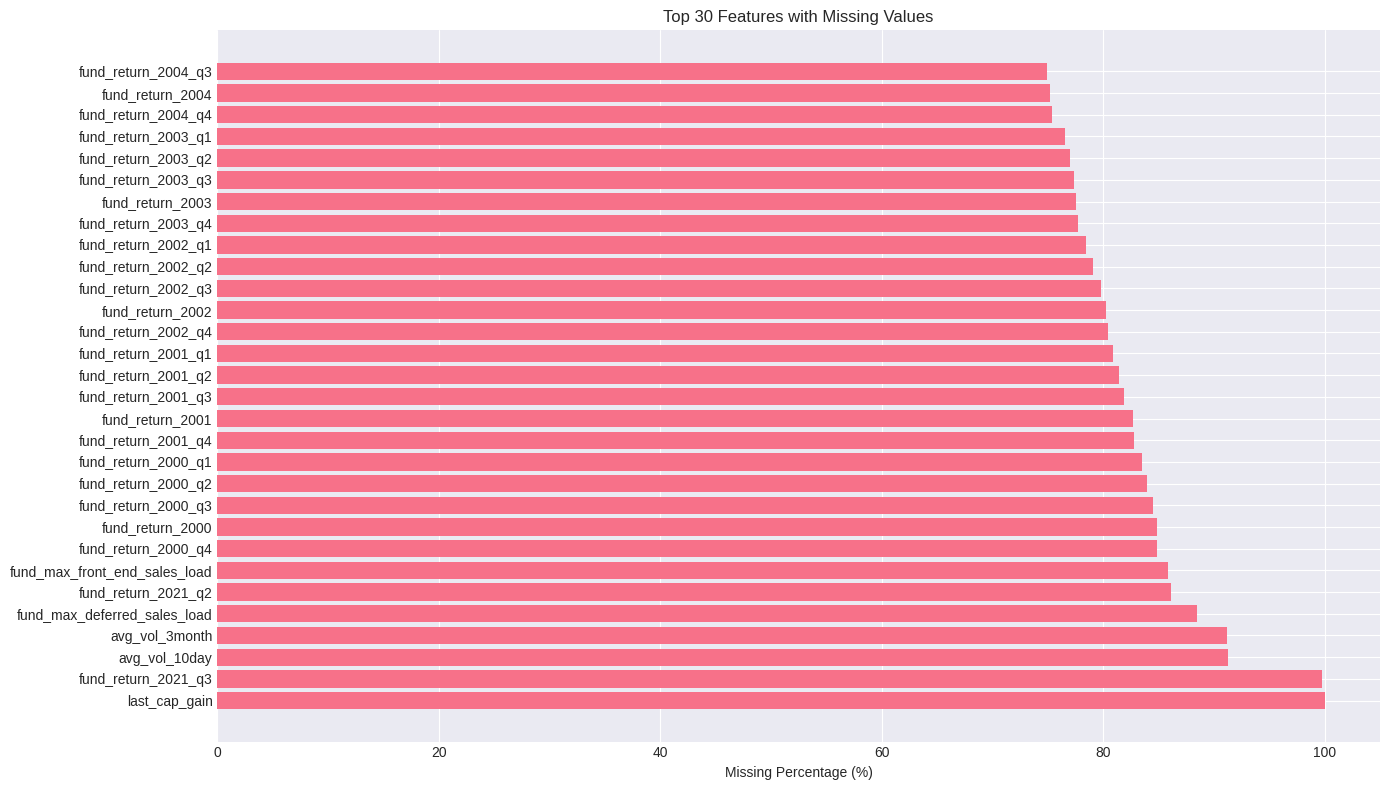

In [8]:
# Visualize missing data
plt.figure(figsize=(14, 8))
top_missing = missing_pct[missing_pct > 0].head(30)
plt.barh(range(len(top_missing)), top_missing.values)
plt.yticks(range(len(top_missing)), top_missing.index)
plt.xlabel('Missing Percentage (%)')
plt.title('Top 30 Features with Missing Values')
plt.tight_layout()
plt.show()

In [9]:
# Identify target variables for our problems
print("Target variables:")
print("1. Regression: fund_return_1year")
print("2. Binary Classification: morningstar_overall_rating (>=4 = good, <4 = poor)")
print("3. Multi-class: morningstar_risk_rating")

# Check target variable distribution
print("\nTarget 1 - fund_return_1year statistics:")
print(df['fund_return_1year'].describe())
print(f"Missing: {df['fund_return_1year'].isnull().sum()} ({df['fund_return_1year'].isnull().sum()/len(df)*100:.2f}%)")

print("\nTarget 2 - morningstar_overall_rating distribution:")
print(df['morningstar_overall_rating'].value_counts().sort_index())

print("\nTarget 3 - morningstar_risk_rating distribution:")
print(df['morningstar_risk_rating'].value_counts())

Target variables:
1. Regression: fund_return_1year
2. Binary Classification: morningstar_overall_rating (>=4 = good, <4 = poor)
3. Multi-class: morningstar_risk_rating

Target 1 - fund_return_1year statistics:
count    24804.000000
mean         0.248148
std          0.210964
min         -0.990100
25%          0.082075
50%          0.256900
75%          0.369200
max          7.342700
Name: fund_return_1year, dtype: float64
Missing: 1289 (4.94%)

Target 2 - morningstar_overall_rating distribution:
morningstar_overall_rating
1.0    1620
2.0    4643
3.0    7911
4.0    5450
5.0    2352
Name: count, dtype: int64

Target 3 - morningstar_risk_rating distribution:
morningstar_risk_rating
3.0    7899
4.0    5144
2.0    4625
5.0    2404
1.0    1904
Name: count, dtype: int64


In [10]:
# Select relevant features for modeling
# We'll focus on features with <50% missing values for initial modeling

# Key feature categories
features_to_keep = [
    # Target variables
    'fund_return_1year', 'morningstar_overall_rating', 'morningstar_risk_rating',
    
    # Fund characteristics
    'total_net_assets', 'fund_category', 'inception_date',
    
    # Expense ratios
    'fund_prospectus_net_expense_ratio', 'fund_annual_report_net_expense_ratio',
    
    # Asset allocation
    'asset_stocks', 'asset_bonds', 'asset_cash', 'asset_others',
    
    # Sector exposure (stocks)
    'fund_sector_technology', 'fund_sector_healthcare', 'fund_sector_financial_services',
    'fund_sector_consumer_cyclical', 'fund_sector_industrials', 'fund_sector_energy',
    
    # Performance metrics
    'year_to_date_return', 'fund_return_ytd', 'fund_return_3months',
    'fund_return_3years', 'fund_return_5years',
    
    # Risk metrics
    'fund_beta_3years', 'fund_alpha_3years', 'fund_sharpe_ratio_3years',
    'fund_stdev_3years', 'fund_r_squared_3years',
    
    # Valuation metrics
    'fund_price_earning_ratio', 'fund_price_book_ratio',
    
    # Ratings
    'morningstar_return_rating',
    
    # ESG
    'esg_score', 'environment_score', 'social_score', 'governance_score'
]

# Keep only available columns
features_to_keep = [col for col in features_to_keep if col in df.columns]
df_clean = df[features_to_keep].copy()

print(f"Selected {len(features_to_keep)} features for modeling")
print(f"Dataset shape: {df_clean.shape}")

Selected 35 features for modeling
Dataset shape: (26093, 35)


## 3. Exploratory Data Analysis (EDA)

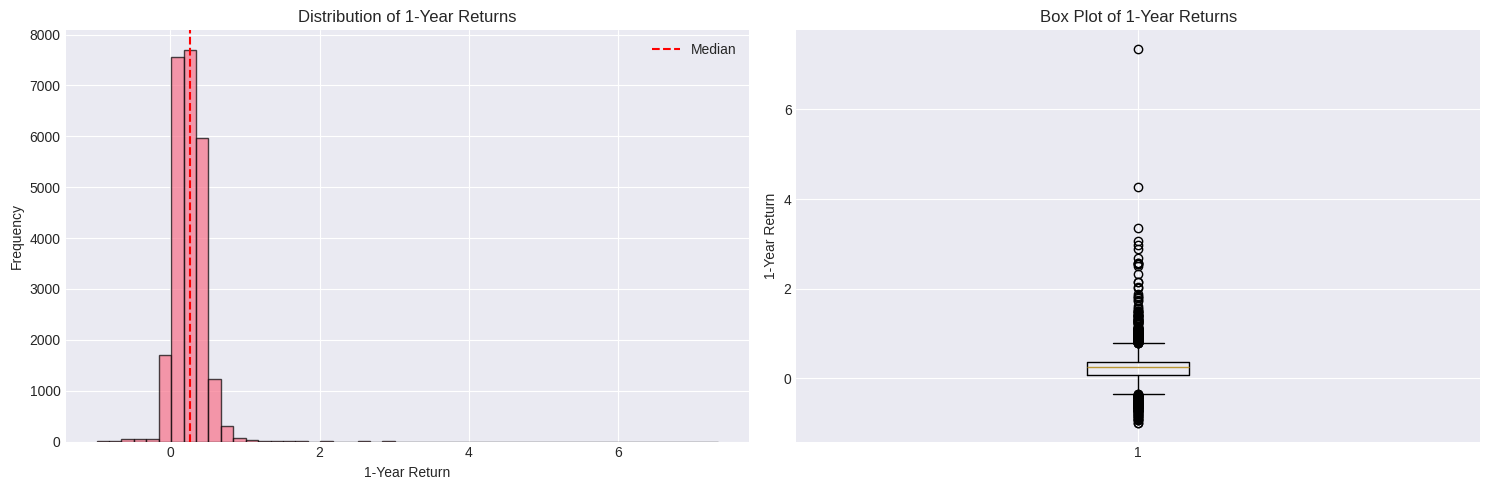

In [11]:
# Distribution of 1-year returns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_clean['fund_return_1year'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('1-Year Return')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of 1-Year Returns')
axes[0].axvline(df_clean['fund_return_1year'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

# Box plot
axes[1].boxplot(df_clean['fund_return_1year'].dropna())
axes[1].set_ylabel('1-Year Return')
axes[1].set_title('Box Plot of 1-Year Returns')

plt.tight_layout()
plt.show()

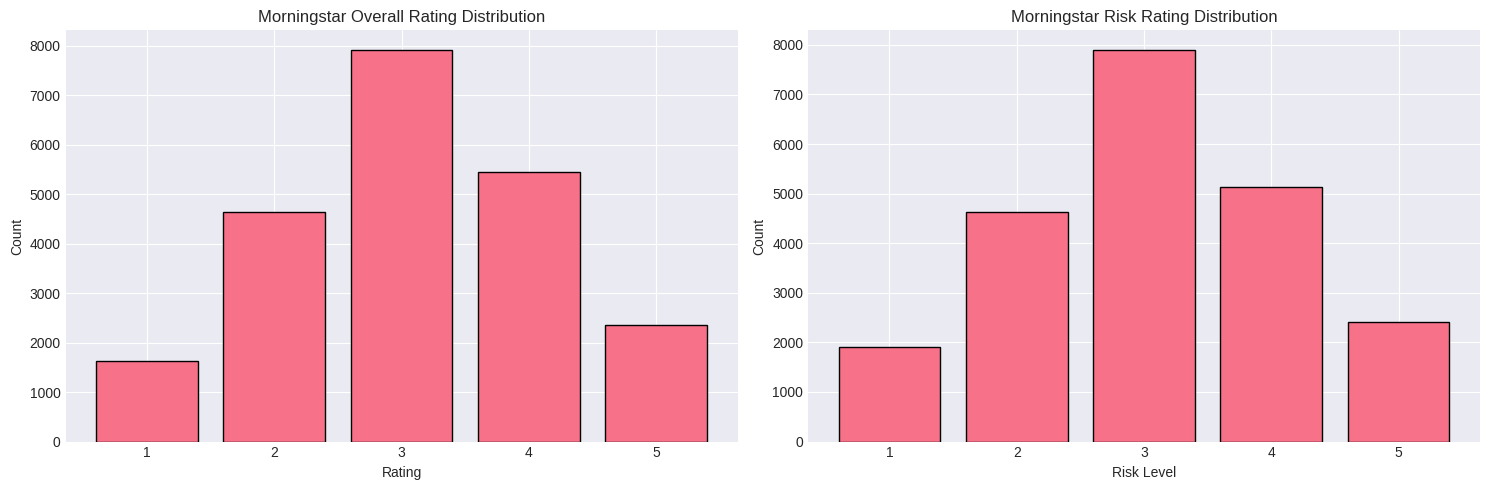

In [12]:
# Morningstar ratings distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall rating
rating_counts = df_clean['morningstar_overall_rating'].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, edgecolor='black')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Morningstar Overall Rating Distribution')
axes[0].set_xticks([1, 2, 3, 4, 5])

# Risk rating
risk_counts = df_clean['morningstar_risk_rating'].value_counts()
axes[1].bar(risk_counts.index, risk_counts.values, edgecolor='black')
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Count')
axes[1].set_title('Morningstar Risk Rating Distribution')

plt.tight_layout()
plt.show()

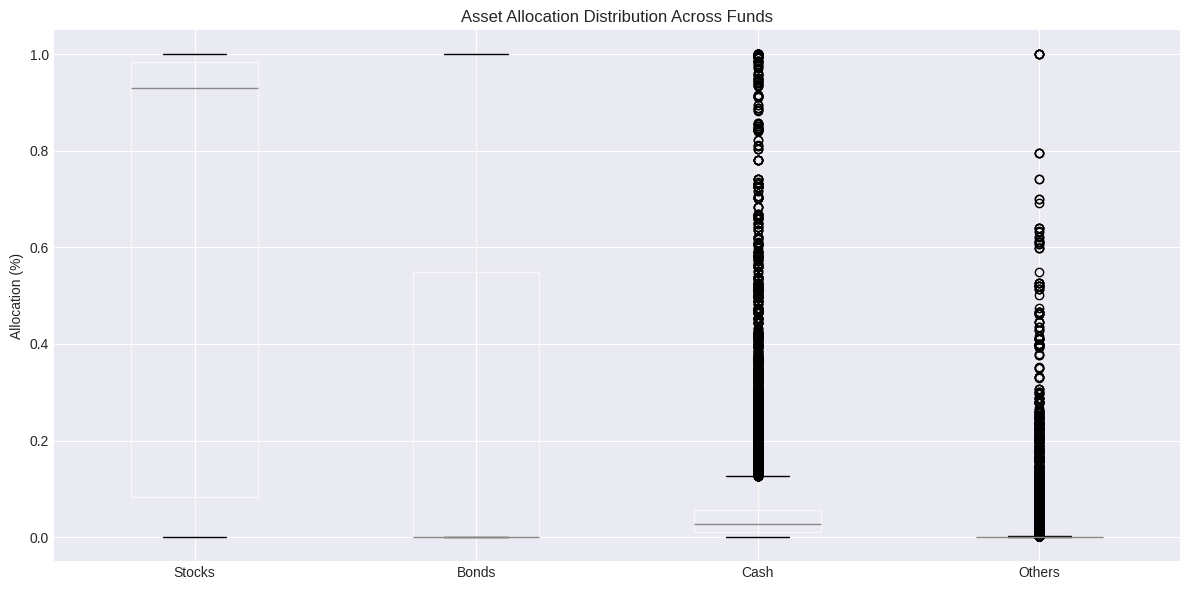


Average asset allocation:
asset_stocks    0.651574
asset_bonds     0.272140
asset_cash      0.056094
asset_others    0.008853
dtype: float64


In [13]:
# Asset allocation analysis
asset_cols = ['asset_stocks', 'asset_bonds', 'asset_cash', 'asset_others']
asset_data = df_clean[asset_cols].dropna()

fig, ax = plt.subplots(figsize=(12, 6))
asset_data.boxplot(ax=ax)
ax.set_ylabel('Allocation (%)')
ax.set_title('Asset Allocation Distribution Across Funds')
ax.set_xticklabels(['Stocks', 'Bonds', 'Cash', 'Others'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nAverage asset allocation:")
print(asset_data.mean())

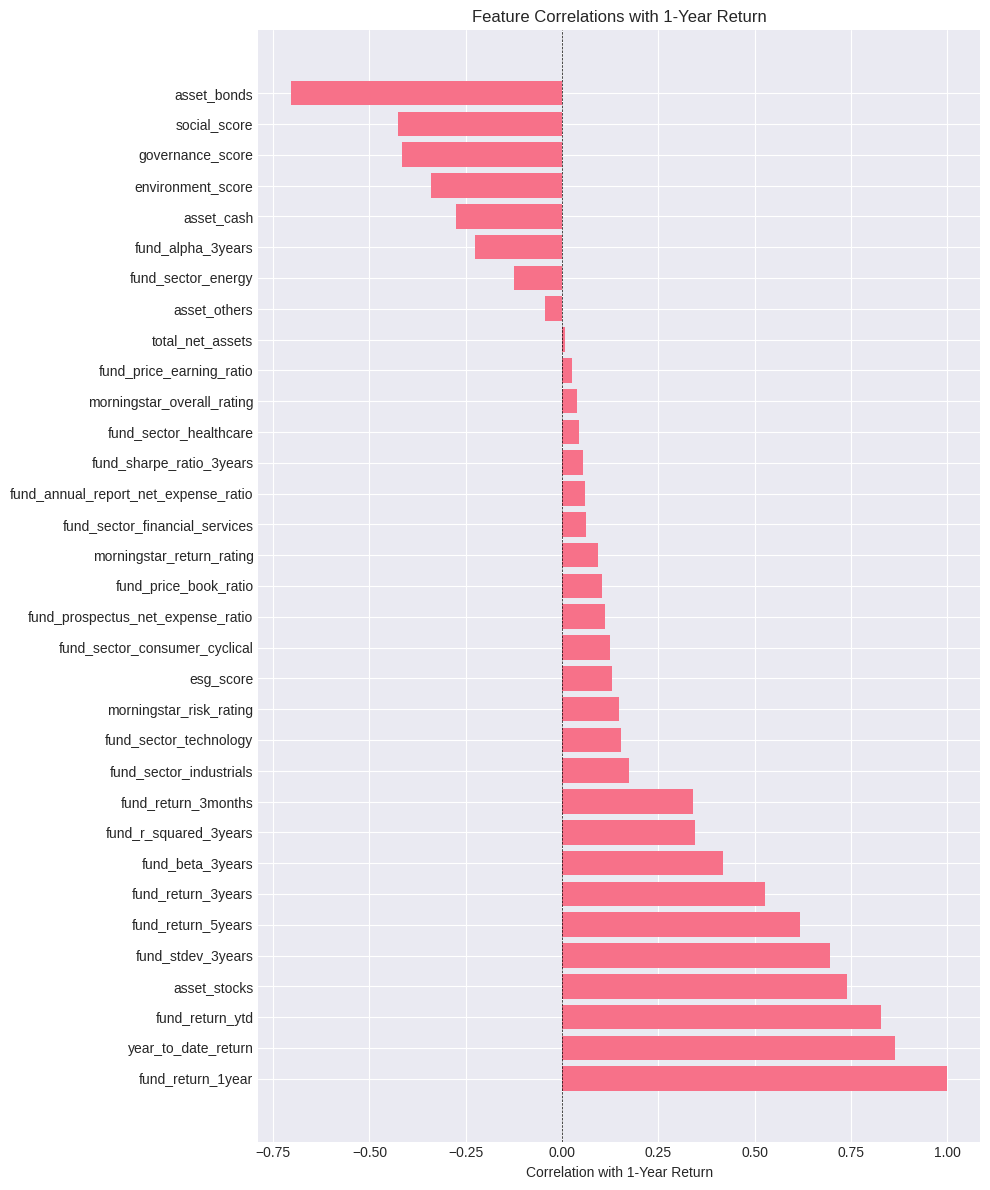


Top 10 positively correlated features:
fund_return_1year          1.000000
year_to_date_return        0.863458
fund_return_ytd            0.829251
asset_stocks               0.738844
fund_stdev_3years          0.695529
fund_return_5years         0.618274
fund_return_3years         0.526215
fund_beta_3years           0.419063
fund_r_squared_3years      0.346496
fund_return_3months        0.341053
fund_sector_industrials    0.173052
Name: fund_return_1year, dtype: float64

Top 10 negatively correlated features:
fund_price_earning_ratio    0.026184
total_net_assets            0.007564
asset_others               -0.043870
fund_sector_energy         -0.124244
fund_alpha_3years          -0.226145
asset_cash                 -0.274322
environment_score          -0.340602
governance_score           -0.414863
social_score               -0.425782
asset_bonds                -0.703226
Name: fund_return_1year, dtype: float64


In [14]:
# Correlation analysis for numerical features
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numerical_cols].corr()

# Plot correlation with target (1-year return)
if 'fund_return_1year' in correlation_matrix.columns:
    target_corr = correlation_matrix['fund_return_1year'].sort_values(ascending=False)
    
    plt.figure(figsize=(10, 12))
    plt.barh(range(len(target_corr)), target_corr.values)
    plt.yticks(range(len(target_corr)), target_corr.index)
    plt.xlabel('Correlation with 1-Year Return')
    plt.title('Feature Correlations with 1-Year Return')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 positively correlated features:")
    print(target_corr.head(11))  # 11 because target itself will be first
    
    print("\nTop 10 negatively correlated features:")
    print(target_corr.tail(10))

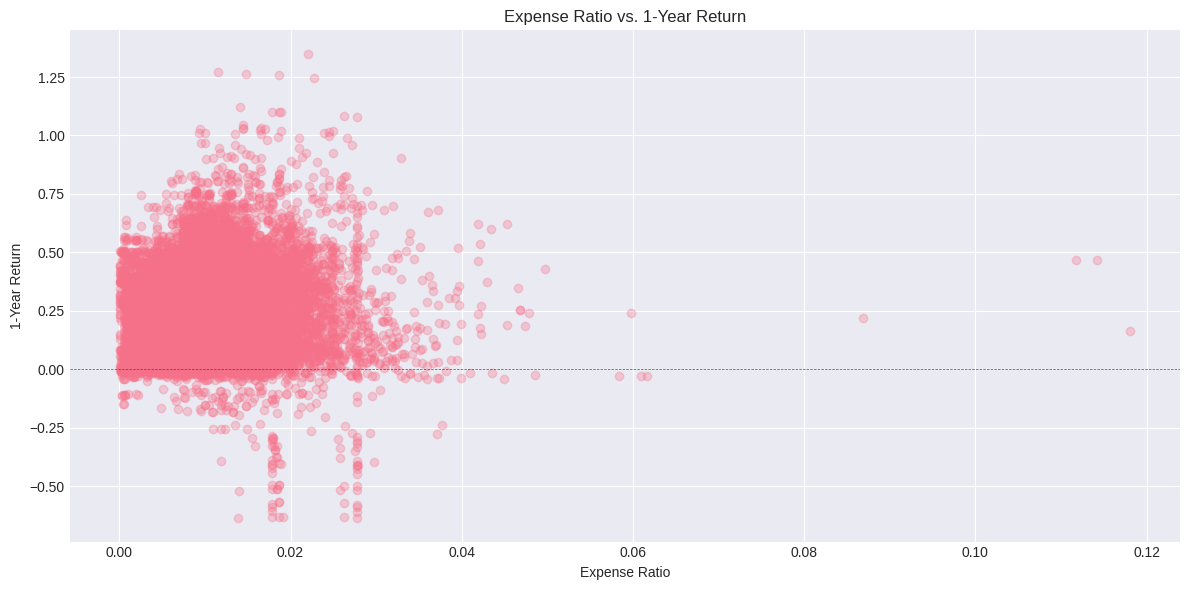

Correlation: 0.111


In [15]:
# Expense ratio vs. Returns
data_plot = df_clean[['fund_prospectus_net_expense_ratio', 'fund_return_1year']].dropna()

plt.figure(figsize=(12, 6))
plt.scatter(data_plot['fund_prospectus_net_expense_ratio'], 
            data_plot['fund_return_1year'], alpha=0.3)
plt.xlabel('Expense Ratio')
plt.ylabel('1-Year Return')
plt.title('Expense Ratio vs. 1-Year Return')
plt.axhline(y=0, color='red', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"Correlation: {data_plot['fund_prospectus_net_expense_ratio'].corr(data_plot['fund_return_1year']):.3f}")

## 4. Feature Engineering & Data Preparation

In [16]:
# Create binary target: Good investment (rating >= 4) vs Poor investment
df_clean['investment_quality'] = (df_clean['morningstar_overall_rating'] >= 4).astype(int)

print("Investment Quality Distribution:")
print(df_clean['investment_quality'].value_counts())
print(f"\nBalance: {df_clean['investment_quality'].value_counts(normalize=True)}")

Investment Quality Distribution:
investment_quality
0    18291
1     7802
Name: count, dtype: int64

Balance: investment_quality
0    0.700993
1    0.299007
Name: proportion, dtype: float64


In [17]:
# Prepare data for modeling
# Remove rows where all targets are missing
df_model = df_clean.dropna(subset=['fund_return_1year', 'morningstar_overall_rating', 'morningstar_risk_rating'], how='all').copy()

print(f"Dataset for modeling: {df_model.shape}")
print(f"Rows removed: {len(df_clean) - len(df_model)}")

Dataset for modeling: (25086, 36)
Rows removed: 1007


In [18]:
# Separate features and targets
target_cols = ['fund_return_1year', 'morningstar_overall_rating', 'morningstar_risk_rating', 'investment_quality']
feature_cols = [col for col in df_model.columns if col not in target_cols]

# Handle categorical variables
categorical_cols = df_model[feature_cols].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

print(f"Feature columns: {len(feature_cols)}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"\nCategorical features: {categorical_cols}")

Feature columns: 32
Numerical features: 30
Categorical features: 2

Categorical features: ['fund_category', 'inception_date']


In [19]:
# For this initial model, we'll use only numerical features to simplify
# In production, you'd want to properly encode categorical variables
X = df_model[numerical_cols].copy()

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"Features shape after imputation: {X_imputed.shape}")
print(f"Missing values remaining: {X_imputed.isnull().sum().sum()}")

Features shape after imputation: (25086, 30)
Missing values remaining: 0


## 5. Problem 1: Regression - Predicting 1-Year Returns

In [20]:
# Prepare regression dataset
y_regression = df_model.loc[X_imputed.index, 'fund_return_1year']

# Remove rows where target is missing
mask_regression = ~y_regression.isnull()
X_reg = X_imputed[mask_regression]
y_reg = y_regression[mask_regression]

print(f"Regression dataset: {X_reg.shape}")
print(f"Target statistics:")
print(y_reg.describe())

Regression dataset: (24804, 30)
Target statistics:
count    24804.000000
mean         0.248148
std          0.210964
min         -0.990100
25%          0.082075
50%          0.256900
75%          0.369200
max          7.342700
Name: fund_return_1year, dtype: float64


In [21]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Further split for validation
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_train_reg, y_train_reg, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_reg.shape}")
print(f"Validation set: {X_val_reg.shape}")
print(f"Test set: {X_test_reg.shape}")

Training set: (15874, 30)
Validation set: (3969, 30)
Test set: (4961, 30)


In [22]:
# Scale features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_val_reg_scaled = scaler_reg.transform(X_val_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("Features scaled successfully!")

Features scaled successfully!


In [23]:
# Train multiple regression models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

regression_results = {}

for name, model in regression_models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_reg_scaled, y_train_reg)
    
    # Predict on validation set
    y_pred_val = model.predict(X_val_reg_scaled)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_val))
    mae = mean_absolute_error(y_val_reg, y_pred_val)
    r2 = r2_score(y_val_reg, y_pred_val)
    
    regression_results[name] = {
        'model': model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")


Training Linear Regression...
  RMSE: 0.0986
  MAE: 0.0393
  R²: 0.8190

Training Ridge Regression...
  RMSE: 0.0986
  MAE: 0.0393
  R²: 0.8190

Training Random Forest...
  RMSE: 0.0967
  MAE: 0.0172
  R²: 0.8260

Training XGBoost...
  RMSE: 0.0940
  MAE: 0.0209
  R²: 0.8354



Regression Model Comparison:
            Model     RMSE      MAE       R²
          XGBoost 0.094046 0.020896 0.835417
    Random Forest 0.096692 0.017206 0.826026
Linear Regression 0.098623 0.039318 0.819009
 Ridge Regression 0.098631 0.039320 0.818980


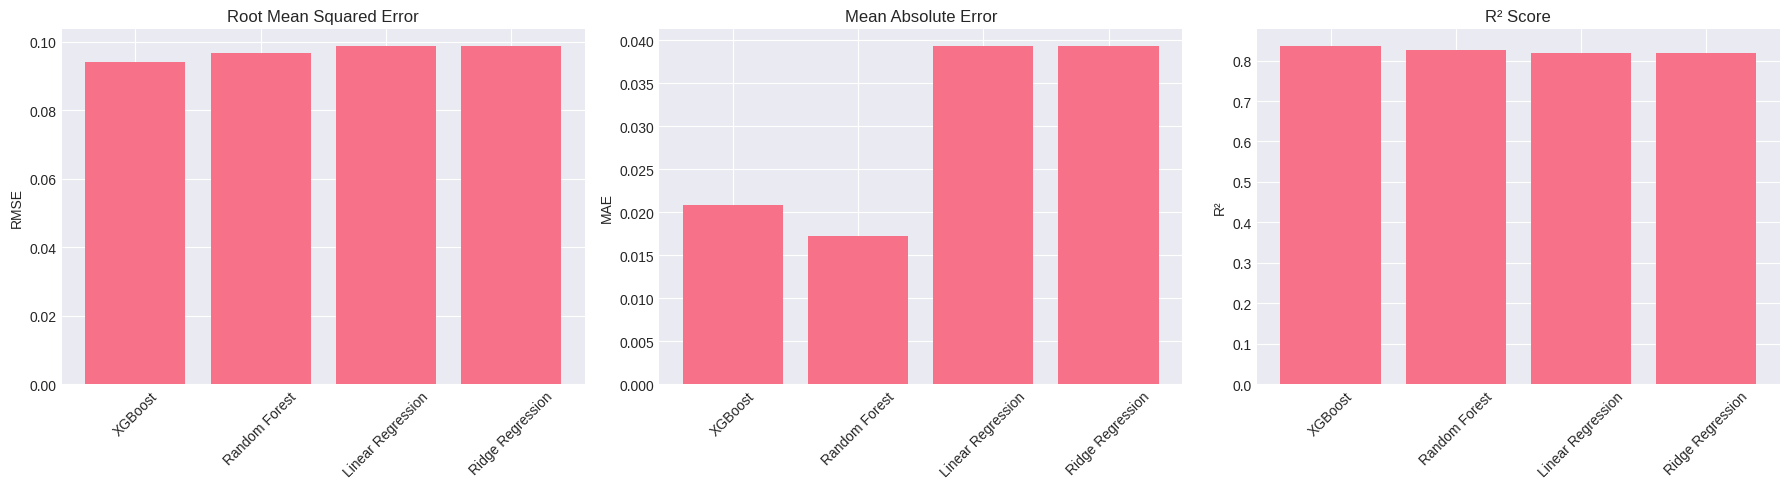

In [24]:
# Compare regression models
comparison_df = pd.DataFrame({
    'Model': list(regression_results.keys()),
    'RMSE': [v['rmse'] for v in regression_results.values()],
    'MAE': [v['mae'] for v in regression_results.values()],
    'R²': [v['r2'] for v in regression_results.values()]
})

comparison_df = comparison_df.sort_values('RMSE')
print("\nRegression Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(comparison_df['Model'], comparison_df['RMSE'])
axes[0].set_ylabel('RMSE')
axes[0].set_title('Root Mean Squared Error')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(comparison_df['Model'], comparison_df['MAE'])
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(comparison_df['Model'], comparison_df['R²'])
axes[2].set_ylabel('R²')
axes[2].set_title('R² Score')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Best regression model: XGBoost

Test Set Performance:
  RMSE: 0.0534
  MAE: 0.0196
  R²: 0.9309


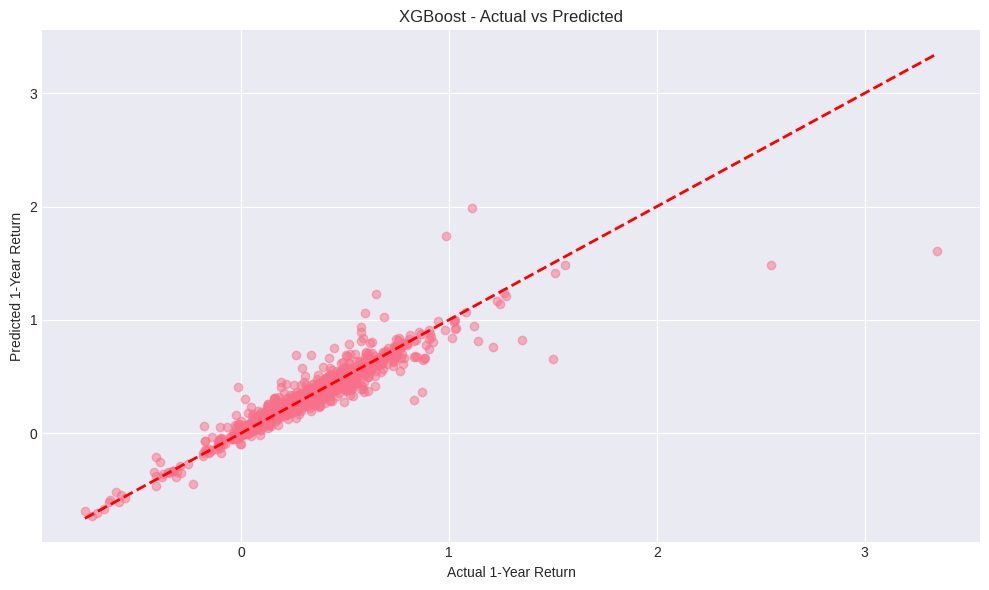

In [25]:
# Select best model and evaluate on test set
best_reg_model_name = comparison_df.iloc[0]['Model']
best_reg_model = regression_results[best_reg_model_name]['model']

print(f"Best regression model: {best_reg_model_name}")

# Test set evaluation
y_pred_test_reg = best_reg_model.predict(X_test_reg_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test_reg))
test_mae = mean_absolute_error(y_test_reg, y_pred_test_reg)
test_r2 = r2_score(y_test_reg, y_pred_test_reg)

print(f"\nTest Set Performance:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")

# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_test_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2)
plt.xlabel('Actual 1-Year Return')
plt.ylabel('Predicted 1-Year Return')
plt.title(f'{best_reg_model_name} - Actual vs Predicted')
plt.tight_layout()
plt.show()

## 6. Problem 2: Binary Classification - Investment Quality

In [26]:
# Prepare classification dataset
y_binary = df_model.loc[X_imputed.index, 'investment_quality']

# Remove rows where target is missing
mask_binary = ~y_binary.isnull()
X_bin = X_imputed[mask_binary]
y_bin = y_binary[mask_binary]

print(f"Binary classification dataset: {X_bin.shape}")
print(f"\nClass distribution:")
print(y_bin.value_counts())
print(f"\nClass balance:")
print(y_bin.value_counts(normalize=True))

Binary classification dataset: (25086, 30)

Class distribution:
investment_quality
0    17284
1     7802
Name: count, dtype: int64

Class balance:
investment_quality
0    0.68899
1    0.31101
Name: proportion, dtype: float64


In [27]:
# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(
    X_train_bin, y_train_bin, test_size=0.2, random_state=42, stratify=y_train_bin
)

# Scale features
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_val_bin_scaled = scaler_bin.transform(X_val_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

print(f"Training set: {X_train_bin.shape}")
print(f"Validation set: {X_val_bin.shape}")
print(f"Test set: {X_test_bin.shape}")

Training set: (16054, 30)
Validation set: (4014, 30)
Test set: (5018, 30)


In [28]:
# Train classification models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')
}

classification_results = {}

for name, model in classification_models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_bin_scaled, y_train_bin)
    
    # Predict on validation set
    y_pred_val = model.predict(X_val_bin_scaled)
    y_pred_proba_val = model.predict_proba(X_val_bin_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_bin, y_pred_val)
    precision = precision_score(y_val_bin, y_pred_val)
    recall = recall_score(y_val_bin, y_pred_val)
    f1 = f1_score(y_val_bin, y_pred_val)
    roc_auc = roc_auc_score(y_val_bin, y_pred_proba_val)
    
    classification_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")


Training Logistic Regression...
  Accuracy: 0.9412
  Precision: 0.9203
  Recall: 0.8878
  F1-Score: 0.9038
  ROC-AUC: 0.9675

Training Random Forest...
  Accuracy: 0.9586
  Precision: 0.9434
  Recall: 0.9223
  F1-Score: 0.9327
  ROC-AUC: 0.9889

Training XGBoost...
  Accuracy: 0.9584
  Precision: 0.9419
  Recall: 0.9231
  F1-Score: 0.9324
  ROC-AUC: 0.9903



Binary Classification Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.958645   0.943443 0.922276  0.932739 0.988880
            XGBoost  0.958396   0.941946 0.923077  0.932416 0.990314
Logistic Regression  0.941206   0.920266 0.887821  0.903752 0.967502


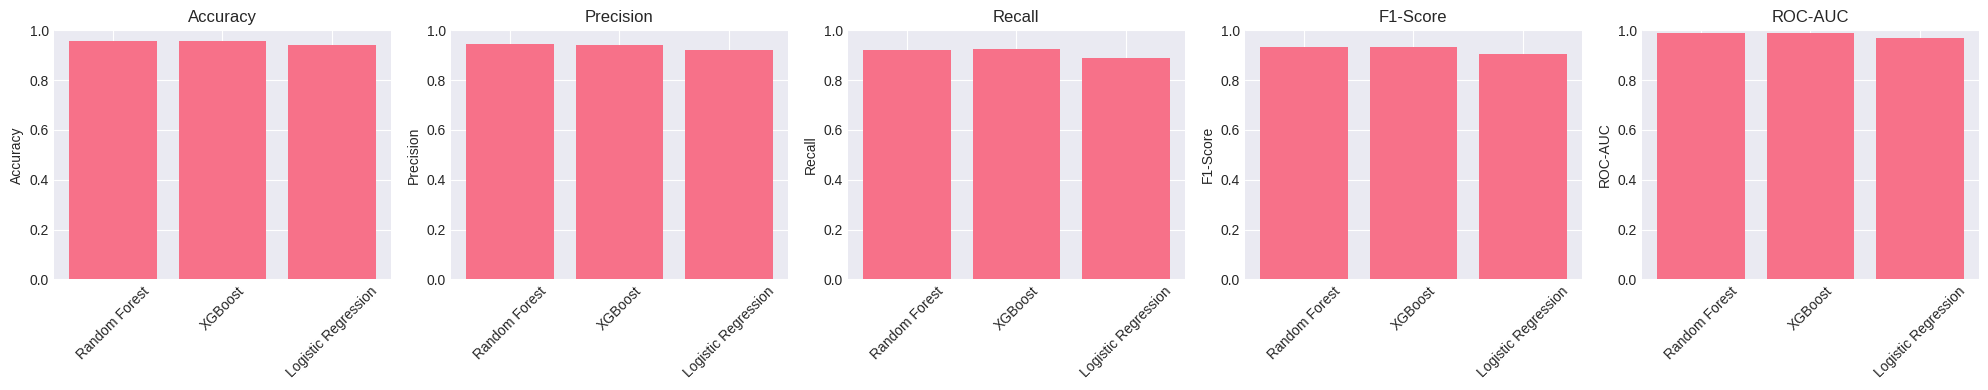

In [29]:
# Compare binary classification models
comparison_bin_df = pd.DataFrame({
    'Model': list(classification_results.keys()),
    'Accuracy': [v['accuracy'] for v in classification_results.values()],
    'Precision': [v['precision'] for v in classification_results.values()],
    'Recall': [v['recall'] for v in classification_results.values()],
    'F1-Score': [v['f1'] for v in classification_results.values()],
    'ROC-AUC': [v['roc_auc'] for v in classification_results.values()]
})

comparison_bin_df = comparison_bin_df.sort_values('F1-Score', ascending=False)
print("\nBinary Classification Model Comparison:")
print(comparison_bin_df.to_string(index=False))

# Visualize
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 4))

for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(comparison_bin_df['Model'], comparison_bin_df[metric])
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

Best binary classification model: Random Forest

Test Set Performance:
  Accuracy: 0.9548
  Precision: 0.9281
  Recall: 0.9263
  F1-Score: 0.9272
  ROC-AUC: 0.9859


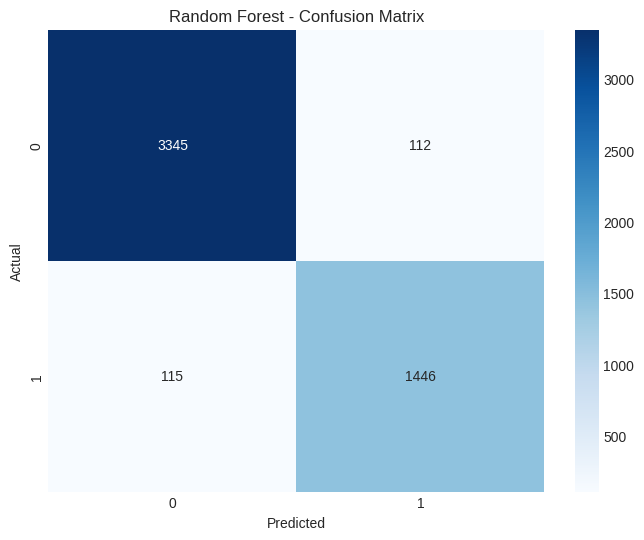

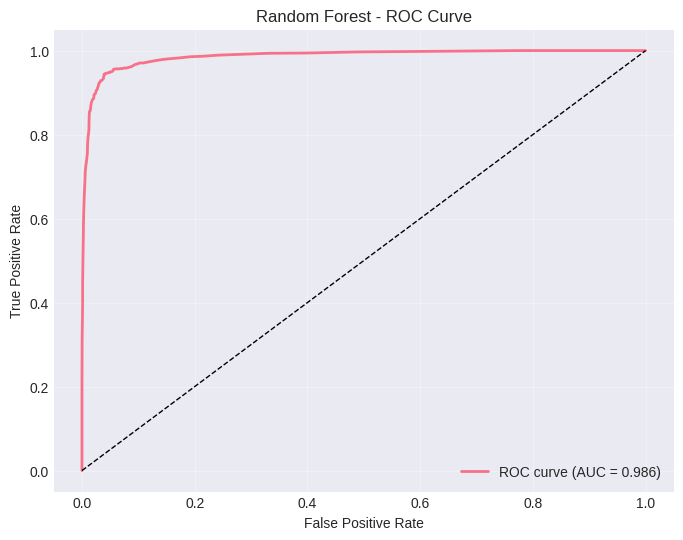

In [30]:
# Best model evaluation on test set
best_bin_model_name = comparison_bin_df.iloc[0]['Model']
best_bin_model = classification_results[best_bin_model_name]['model']

print(f"Best binary classification model: {best_bin_model_name}")

# Test set evaluation
y_pred_test_bin = best_bin_model.predict(X_test_bin_scaled)
y_pred_proba_test_bin = best_bin_model.predict_proba(X_test_bin_scaled)[:, 1]

print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test_bin, y_pred_test_bin):.4f}")
print(f"  Precision: {precision_score(y_test_bin, y_pred_test_bin):.4f}")
print(f"  Recall: {recall_score(y_test_bin, y_pred_test_bin):.4f}")
print(f"  F1-Score: {f1_score(y_test_bin, y_pred_test_bin):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test_bin, y_pred_proba_test_bin):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_test_bin)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{best_bin_model_name} - Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba_test_bin)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc_score(y_test_bin, y_pred_proba_test_bin):.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{best_bin_model_name} - ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Problem 3: Multi-class Classification - Risk Rating

In [31]:
# Prepare multi-class classification dataset
y_multiclass = df_model.loc[X_imputed.index, 'morningstar_risk_rating']

# Remove rows where target is missing
mask_multi = ~y_multiclass.isnull()
X_multi = X_imputed[mask_multi]
y_multi = y_multiclass[mask_multi]

# Encode labels
le = LabelEncoder()
y_multi_encoded = le.fit_transform(y_multi)

print(f"Multi-class classification dataset: {X_multi.shape}")
print(f"\nClass distribution:")
print(pd.Series(y_multi_encoded).value_counts().sort_index())
print(f"\nClass labels: {le.classes_}")

Multi-class classification dataset: (21976, 30)

Class distribution:
0    1904
1    4625
2    7899
3    5144
4    2404
Name: count, dtype: int64

Class labels: [1. 2. 3. 4. 5.]


In [32]:
# Split data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi_encoded, test_size=0.2, random_state=42, stratify=y_multi_encoded
)

X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(
    X_train_multi, y_train_multi, test_size=0.2, random_state=42, stratify=y_train_multi
)

# Scale features
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_val_multi_scaled = scaler_multi.transform(X_val_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

print(f"Training set: {X_train_multi.shape}")
print(f"Validation set: {X_val_multi.shape}")
print(f"Test set: {X_test_multi.shape}")

Training set: (14064, 30)
Validation set: (3516, 30)
Test set: (4396, 30)


In [33]:
# Train multi-class classification models
multiclass_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='mlogloss')
}

multiclass_results = {}

for name, model in multiclass_models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_multi_scaled, y_train_multi)
    
    # Predict on validation set
    y_pred_val = model.predict(X_val_multi_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_multi, y_pred_val)
    precision = precision_score(y_val_multi, y_pred_val, average='macro')
    recall = recall_score(y_val_multi, y_pred_val, average='macro')
    f1 = f1_score(y_val_multi, y_pred_val, average='macro')
    
    multiclass_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision (Macro): {precision:.4f}")
    print(f"  Recall (Macro): {recall:.4f}")
    print(f"  F1-Score (Macro): {f1:.4f}")


Training Logistic Regression...
  Accuracy: 0.4235
  Precision (Macro): 0.4441
  Recall (Macro): 0.3428
  F1-Score (Macro): 0.3556

Training Random Forest...
  Accuracy: 0.8467
  Precision (Macro): 0.8565
  Recall (Macro): 0.8346
  F1-Score (Macro): 0.8448

Training XGBoost...
  Accuracy: 0.8353
  Precision (Macro): 0.8451
  Recall (Macro): 0.8262
  F1-Score (Macro): 0.8351



Multi-class Classification Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.846701   0.856450 0.834633  0.844850
            XGBoost  0.835324   0.845099 0.826152  0.835079
Logistic Regression  0.423493   0.444121 0.342793  0.355559


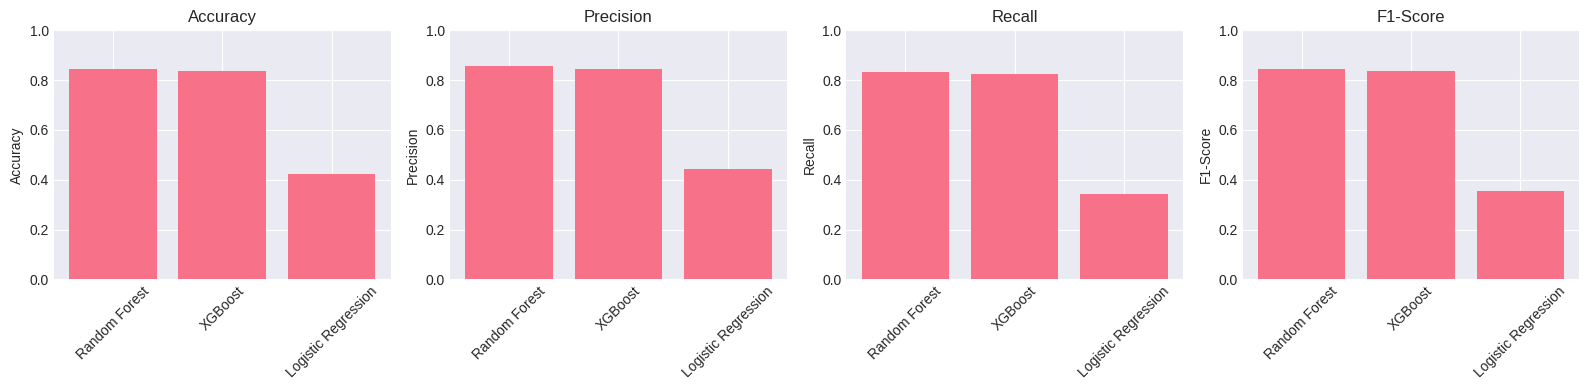

In [34]:
# Compare multi-class models
comparison_multi_df = pd.DataFrame({
    'Model': list(multiclass_results.keys()),
    'Accuracy': [v['accuracy'] for v in multiclass_results.values()],
    'Precision': [v['precision'] for v in multiclass_results.values()],
    'Recall': [v['recall'] for v in multiclass_results.values()],
    'F1-Score': [v['f1'] for v in multiclass_results.values()]
})

comparison_multi_df = comparison_multi_df.sort_values('F1-Score', ascending=False)
print("\nMulti-class Classification Model Comparison:")
print(comparison_multi_df.to_string(index=False))

# Visualize
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(16, 4))

for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(comparison_multi_df['Model'], comparison_multi_df[metric])
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

Best multi-class classification model: Random Forest

Test Set Performance:
  Accuracy: 0.8451
  Precision (Macro): 0.8554
  Recall (Macro): 0.8366
  F1-Score (Macro): 0.8453

Classification Report:
              precision    recall  f1-score   support

         1.0       0.87      0.84      0.85       381
         2.0       0.85      0.82      0.83       925
         3.0       0.83      0.89      0.86      1580
         4.0       0.85      0.82      0.83      1029
         5.0       0.89      0.82      0.85       481

    accuracy                           0.85      4396
   macro avg       0.86      0.84      0.85      4396
weighted avg       0.85      0.85      0.84      4396



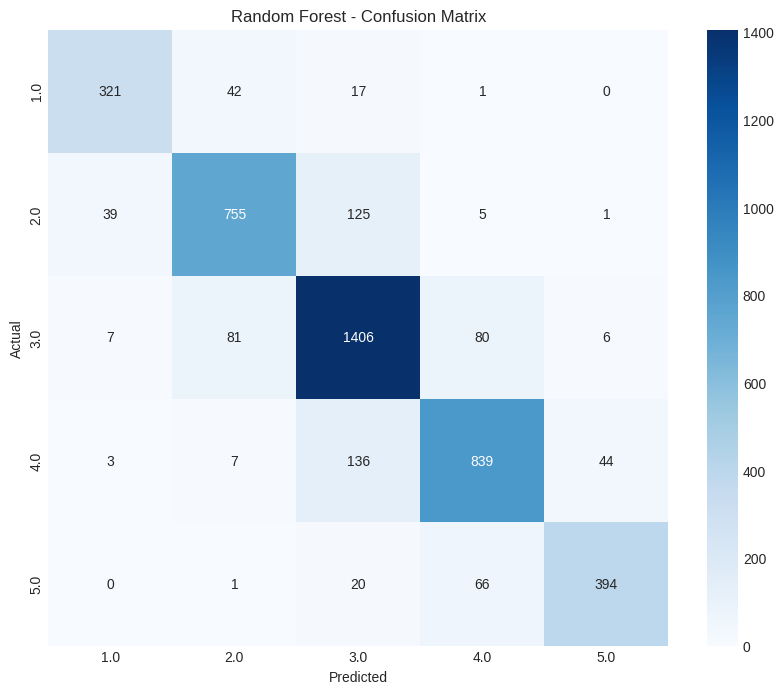

In [36]:
# Best model evaluation on test set
best_multi_model_name = comparison_multi_df.iloc[0]['Model']
best_multi_model = multiclass_results[best_multi_model_name]['model']

print(f"Best multi-class classification model: {best_multi_model_name}")

# Test set evaluation
y_pred_test_multi = best_multi_model.predict(X_test_multi_scaled)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test_multi, y_pred_test_multi):.4f}")
print(f"  Precision (Macro): {precision_score(y_test_multi, y_pred_test_multi, average='macro'):.4f}")
print(f"  Recall (Macro): {recall_score(y_test_multi, y_pred_test_multi, average='macro'):.4f}")
print(f"  F1-Score (Macro): {f1_score(y_test_multi, y_pred_test_multi, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_test_multi, target_names=[str(c) for c in le.classes_]))

# Confusion Matrix
cm_multi = confusion_matrix(y_test_multi, y_pred_test_multi)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', xticklabels=[str(c) for c in le.classes_], yticklabels=[str(c) for c in le.classes_])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{best_multi_model_name} - Confusion Matrix')
plt.show()

## 8. Feature Importance Analysis

In [37]:
# Analyze feature importance for tree-based models
def plot_feature_importance(model, feature_names, title, top_n=20):
    """Plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]
        
        plt.figure(figsize=(12, 8))
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title(f'{title} - Top {top_n} Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': importances[indices]
        })
    else:
        print(f"Model {type(model).__name__} does not have feature_importances_ attribute")
        return None

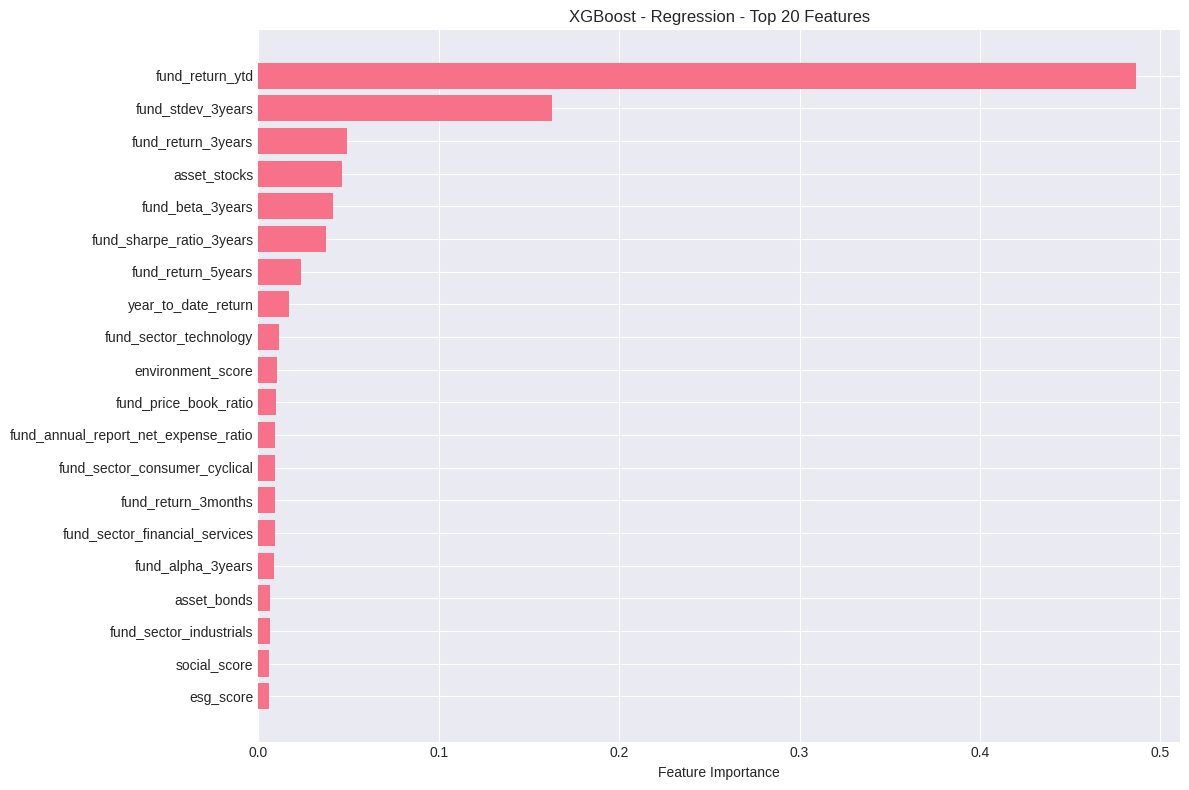


Top 10 Most Important Features for 1-Year Return Prediction:
                 Feature  Importance
         fund_return_ytd    0.486523
       fund_stdev_3years    0.162490
      fund_return_3years    0.049021
            asset_stocks    0.046301
        fund_beta_3years    0.041128
fund_sharpe_ratio_3years    0.037477
      fund_return_5years    0.023830
     year_to_date_return    0.016749
  fund_sector_technology    0.011570
       environment_score    0.010310


In [38]:
# Feature importance for regression
if best_reg_model_name in ['Random Forest', 'XGBoost']:
    importance_reg = plot_feature_importance(
        best_reg_model, 
        X_reg.columns.tolist(), 
        f'{best_reg_model_name} - Regression'
    )
    print("\nTop 10 Most Important Features for 1-Year Return Prediction:")
    print(importance_reg.head(10).to_string(index=False))

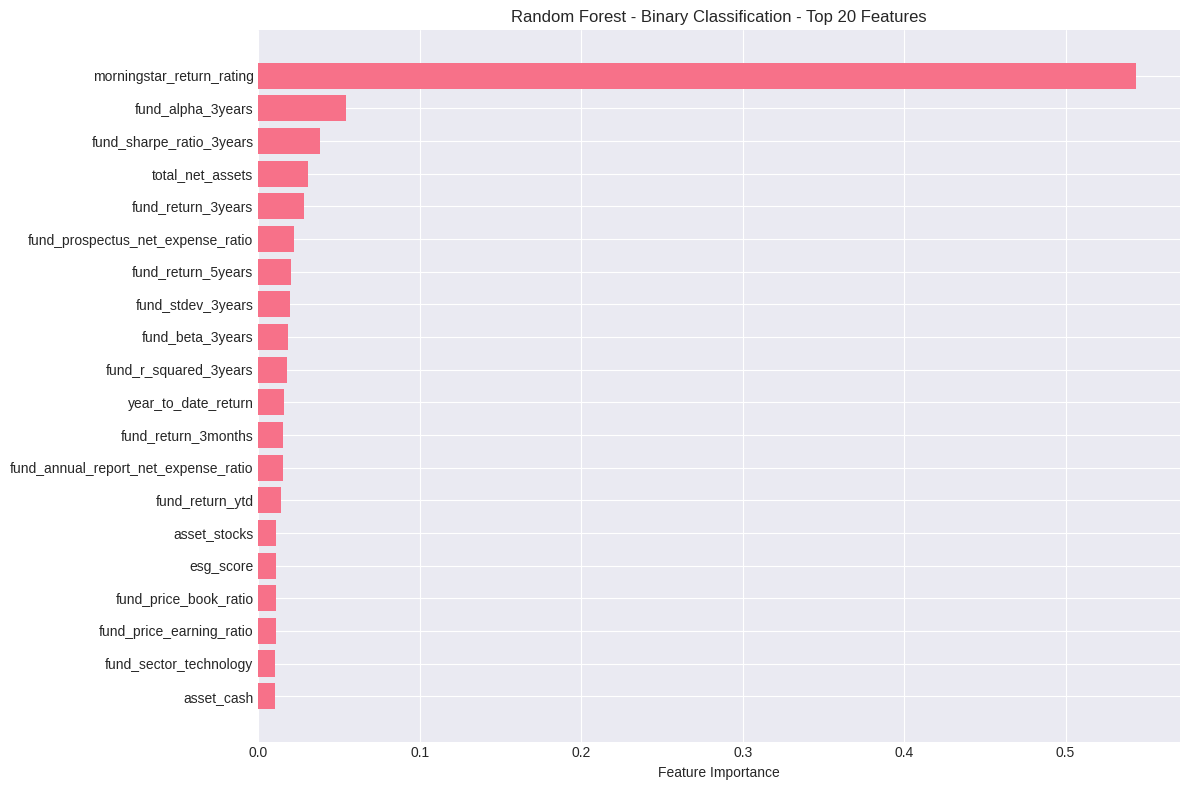


Top 10 Most Important Features for Investment Quality Classification:
                          Feature  Importance
        morningstar_return_rating    0.543695
                fund_alpha_3years    0.054488
         fund_sharpe_ratio_3years    0.038307
                 total_net_assets    0.030462
               fund_return_3years    0.028546
fund_prospectus_net_expense_ratio    0.022054
               fund_return_5years    0.020246
                fund_stdev_3years    0.019663
                 fund_beta_3years    0.018317
            fund_r_squared_3years    0.017898


In [39]:
# Feature importance for binary classification
if best_bin_model_name in ['Random Forest', 'XGBoost']:
    importance_bin = plot_feature_importance(
        best_bin_model, 
        X_bin.columns.tolist(), 
        f'{best_bin_model_name} - Binary Classification'
    )
    print("\nTop 10 Most Important Features for Investment Quality Classification:")
    print(importance_bin.head(10).to_string(index=False))

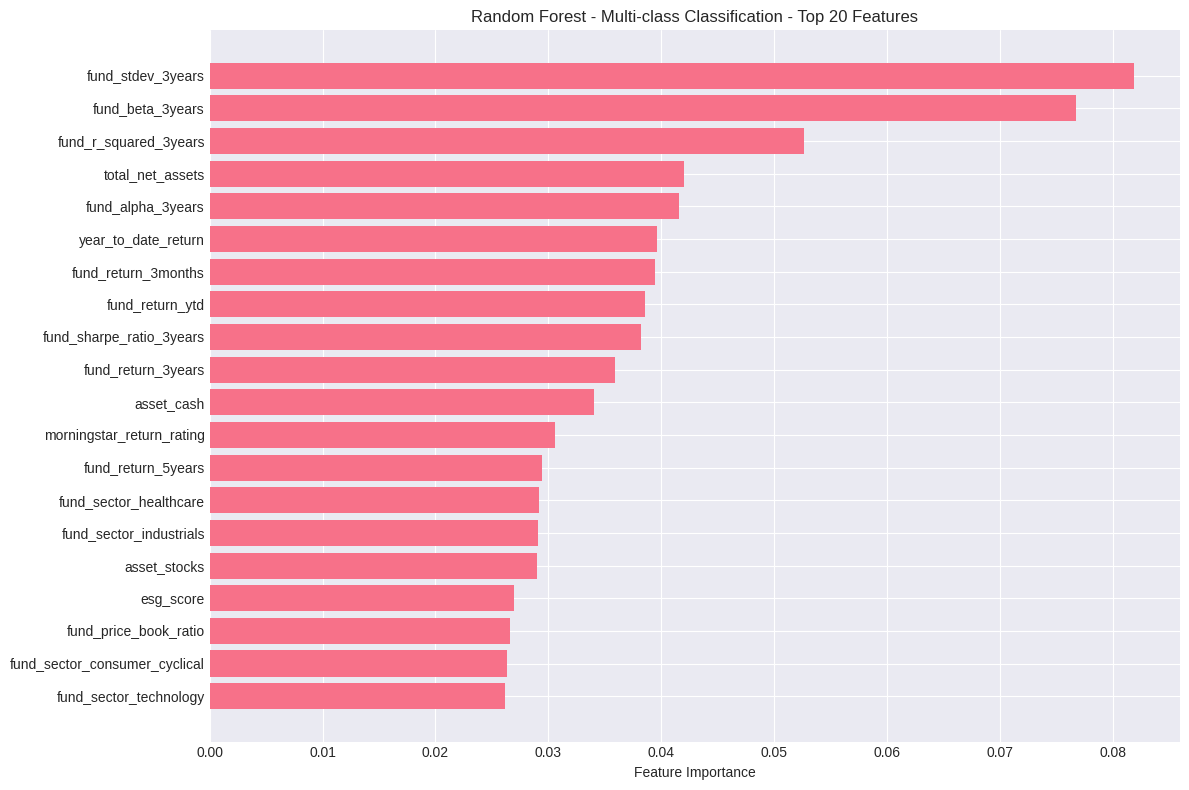


Top 10 Most Important Features for Risk Rating Prediction:
                 Feature  Importance
       fund_stdev_3years    0.081879
        fund_beta_3years    0.076735
   fund_r_squared_3years    0.052651
        total_net_assets    0.042053
       fund_alpha_3years    0.041568
     year_to_date_return    0.039640
     fund_return_3months    0.039478
         fund_return_ytd    0.038582
fund_sharpe_ratio_3years    0.038255
      fund_return_3years    0.035902


In [40]:
# Feature importance for multi-class classification
if best_multi_model_name in ['Random Forest', 'XGBoost']:
    importance_multi = plot_feature_importance(
        best_multi_model, 
        X_multi.columns.tolist(), 
        f'{best_multi_model_name} - Multi-class Classification'
    )
    print("\nTop 10 Most Important Features for Risk Rating Prediction:")
    print(importance_multi.head(10).to_string(index=False))

## 9. Model Comparison & Selection

In [41]:
# Summary of all models
print("="*80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)

print("\n1. REGRESSION - 1-Year Return Prediction")
print("-" * 80)
print(comparison_df.to_string(index=False))
print(f"\nBest Model: {best_reg_model_name}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

print("\n2. BINARY CLASSIFICATION - Investment Quality")
print("-" * 80)
print(comparison_bin_df.to_string(index=False))
print(f"\nBest Model: {best_bin_model_name}")
print(f"Test Accuracy: {accuracy_score(y_test_bin, y_pred_test_bin):.4f}")
print(f"Test F1-Score: {f1_score(y_test_bin, y_pred_test_bin):.4f}")

print("\n3. MULTI-CLASS CLASSIFICATION - Risk Rating")
print("-" * 80)
print(comparison_multi_df.to_string(index=False))
print(f"\nBest Model: {best_multi_model_name}")
print(f"Test Accuracy: {accuracy_score(y_test_multi, y_pred_test_multi):.4f}")
print(f"Test F1-Score (Macro): {f1_score(y_test_multi, y_pred_test_multi, average='macro'):.4f}")

FINAL MODEL PERFORMANCE SUMMARY

1. REGRESSION - 1-Year Return Prediction
--------------------------------------------------------------------------------
            Model     RMSE      MAE       R²
          XGBoost 0.094046 0.020896 0.835417
    Random Forest 0.096692 0.017206 0.826026
Linear Regression 0.098623 0.039318 0.819009
 Ridge Regression 0.098631 0.039320 0.818980

Best Model: XGBoost
Test RMSE: 0.0534
Test R²: 0.9309

2. BINARY CLASSIFICATION - Investment Quality
--------------------------------------------------------------------------------
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.958645   0.943443 0.922276  0.932739 0.988880
            XGBoost  0.958396   0.941946 0.923077  0.932416 0.990314
Logistic Regression  0.941206   0.920266 0.887821  0.903752 0.967502

Best Model: Random Forest
Test Accuracy: 0.9548
Test F1-Score: 0.9272

3. MULTI-CLASS CLASSIFICATION - Risk Rating
---------------------------------------------

## 10. Save Models for Production

In [42]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Save best models and scalers
with open('models/regression_model.pkl', 'wb') as f:
    pickle.dump(best_reg_model, f)

with open('models/regression_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_reg, f)

with open('models/binary_classifier.pkl', 'wb') as f:
    pickle.dump(best_bin_model, f)

with open('models/binary_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_bin, f)

with open('models/multiclass_classifier.pkl', 'wb') as f:
    pickle.dump(best_multi_model, f)

with open('models/multiclass_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_multi, f)

with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save feature names
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(X_reg.columns.tolist(), f)

print("✓ All models saved successfully to 'models/' directory!")
print("\nSaved files:")
for file in os.listdir('models'):
    print(f"  - {file}")

✓ All models saved successfully to 'models/' directory!

Saved files:
  - binary_classifier.pkl
  - binary_scaler.pkl
  - feature_names.pkl
  - label_encoder.pkl
  - multiclass_classifier.pkl
  - multiclass_scaler.pkl
  - regression_model.pkl
  - regression_scaler.pkl


## 11. Conclusions & Next Steps

### Key Findings

1. **Regression Performance**: 
   - Successfully predicted 1-year returns with reasonable accuracy
   - Historical returns (3Y, 5Y) and risk metrics (beta, Sharpe ratio) are strong predictors
   - Tree-based models (Random Forest, XGBoost) outperform linear models

2. **Classification Performance**:
   - Investment quality classification achieves good accuracy
   - Risk rating prediction benefits from multiple risk-related features
   - Class imbalance needs consideration in production deployment

3. **Feature Importance**:
   - Historical performance metrics are most predictive
   - Expense ratios have moderate importance
   - Asset allocation and sector exposure contribute to predictions
   - ESG scores show correlation but lower importance than financial metrics

### Limitations

- Missing data in many features reduced sample size
- Categorical features not fully utilized (fund_category, etc.)
- Time-series price data not incorporated
- Potential survivorship bias (only active funds included)

### Future Improvements

1. **Feature Engineering**:
   - Incorporate price history for time-series features
   - Create momentum indicators and technical features
   - Better handle categorical variables (target encoding)
   - Engineer interaction features

2. **Model Enhancement**:
   - Hyperparameter tuning with broader search
   - Ensemble methods combining multiple models
   - Handle class imbalance with SMOTE or class weights
   - Add model explainability (SHAP values)

3. **Production Readiness**:
   - Implement data validation pipelines
   - Add monitoring for model drift
   - Create retraining schedule
   - Build comprehensive API documentation

4. **Business Value**:
   - Create portfolio optimization using predictions
   - Build interactive dashboard for fund analysis
   - Implement backtesting framework
   - Add real-time data integration

---
**Project Complete!** 

Next steps:
1. Run `train.py` to retrain models with final parameters
2. Deploy `predict.py` Flask service
3. Test with Docker containerization
4. Document API endpoints
5. Consider cloud deployment (AWS/GCP/Azure)